In [ ]:
!pip install transformers datasets evaluate optimum

In [ ]:
# Remove old model folder if it exists
if os.path.exists(save_path):
    shutil.rmtree(save_path)
    print(f"Removed old folder: {save_path}")

# Remove old zip file if it exists
if os.path.exists(zip_path):
    os.remove(zip_path)
    print(f"Removed old zip: {zip_path}")

# (Optional) Clean up ALL models and zips in one go:
# shutil.rmtree(OUTPUT_DIR)
# os.makedirs(OUTPUT_DIR, exist_ok=True)


In [43]:
import os
import shutil

# Define paths
OUTPUT_DIR = "./bert_models"
OUTPUT_NAME = "agnews_clean"  # Change as needed
save_path = os.path.join(OUTPUT_DIR, OUTPUT_NAME)
zip_path = f"{save_path}.zip"



In [44]:
# ==== 1. Imports and Setup ====
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import os
import shutil

In [45]:
# ==== 2. Config ====
MODEL_NAME = "bert-base-uncased"  # Or use "distilbert-base-uncased" if low on space
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5
OUTPUT_DIR = "./bert_models"
DATASET_CONFIG = {
    "sst2": {
        "dataset_name": "glue",
        "subset": "sst2",
        "text_col": "sentence",
        "num_labels": 2,
        "output_name": "sst2_clean"
    },
    "olid": {
        "dataset_name": "tweet_eval",
        "subset": "offensive",
        "text_col": "text",
        "num_labels": 2,
        "output_name": "olid_clean"
    },
    "agnews": {
        "dataset_name": "ag_news",
        "subset": None,
        "text_col": "text",
        "num_labels": 4,
        "output_name": "agnews_clean"
    }
}

In [46]:
# Choose which dataset to run
CHOSEN = "agnews"  # Change to "olid" or "agnews" as needed

cfg = DATASET_CONFIG[CHOSEN]
save_path = os.path.join(OUTPUT_DIR, cfg["output_name"])

In [29]:
# ==== 3. Clean output folder before training ====
os.makedirs(OUTPUT_DIR, exist_ok=True)
if os.path.exists(save_path):
    shutil.rmtree(save_path)
zip_path = f"{save_path}.zip"
if os.path.exists(zip_path):
    os.remove(zip_path)

In [47]:
# ==== 4. Tokenizer and Dataset ====
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def load_and_tokenize(dataset_name, subset=None, text_col="text"):
    ds = load_dataset(dataset_name, subset) if subset else load_dataset(dataset_name)
    def tokenize_fn(examples):
        return tokenizer(
            examples[text_col],
            padding="max_length",
            truncation=True,
            max_length=128
        )
    tokenized = ds.map(tokenize_fn, batched=True)
    return tokenized

dataset = load_and_tokenize(cfg["dataset_name"], cfg["subset"], cfg["text_col"])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file tokenizer.json from cache at /root/.cache/

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [48]:
# ==== 5. Model, TrainingArgs, Trainer ====
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=cfg["num_labels"])
training_args = TrainingArguments(
    output_dir=save_path,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    logging_dir=os.path.join(save_path, "logs"),
    disable_tqdm=False,
    report_to="none",
    save_strategy="no"  # Only final model
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"] if "validation" in dataset else dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

# ==== 6. Train Model ====
trainer.train()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights 

Step,Training Loss
500,0.408700
1000,0.258900
1500,0.233100
2000,0.225600
2500,0.227400
3000,0.235600
3500,0.209500
4000,0.209100
4500,0.200700
5000,0.192500




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=15000, training_loss=0.17641147232055665, metrics={'train_runtime': 3133.8991, 'train_samples_per_second': 76.582, 'train_steps_per_second': 4.786, 'total_flos': 1.578694680576e+16, 'train_loss': 0.17641147232055665, 'epoch': 2.0})

In [49]:
# ==== 7. Save model and tokenizer ====
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Saved model to {save_path}")

Configuration saved in ./bert_models/agnews_clean/config.json
Model weights saved in ./bert_models/agnews_clean/model.safetensors
tokenizer config file saved in ./bert_models/agnews_clean/tokenizer_config.json
Special tokens file saved in ./bert_models/agnews_clean/special_tokens_map.json


Saved model to ./bert_models/agnews_clean


In [50]:
# ==== 8. Zip for Download/Archive ====
os.system(f"zip -r {zip_path} {save_path}")
print(f"Zipped model to {zip_path}")

# ==== 9. Download model from Kaggle sidebar when done! ====


  adding: bert_models/agnews_clean/ (stored 0%)
  adding: bert_models/agnews_clean/special_tokens_map.json (deflated 42%)
  adding: bert_models/agnews_clean/config.json (deflated 52%)
  adding: bert_models/agnews_clean/tokenizer_config.json (deflated 75%)
  adding: bert_models/agnews_clean/tokenizer.json (deflated 71%)
  adding: bert_models/agnews_clean/model.safetensors (deflated 7%)
  adding: bert_models/agnews_clean/vocab.txt (deflated 53%)
Zipped model to ./bert_models/agnews_clean.zip


# Evaluation

In [16]:
# ---- Imports ----
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [2]:
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset
import pandas as pd
import torch

# 1. Path to your uploaded model folder (no zip)
model_path = "/kaggle/input/sst2-clean/bert_models/olid_clean"

# 2. Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': '/kaggle/input/sst2-clean/bert_models/olid_clean'. Use `repo_type` argument if needed.

In [18]:
model_path = "/kaggle/input/agnews-clean/bert_models/agnews_clean"

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

from datasets import load_dataset
import pandas as pd

# Load AG News dataset (use test split for evaluation)
agnews = load_dataset("ag_news")

def tokenize_fn(examples):
    return tokenizer(
        examples["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=128
    )
tokenized = agnews.map(tokenize_fn, batched=True)
eval_dataset = tokenized["test"]

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1': f1}

eval_args = TrainingArguments(output_dir="./tmp_eval", per_device_eval_batch_size=16, report_to="none")
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics, 
)
metrics = trainer.evaluate()
print("\nEvaluation Metrics:")
print(metrics)

preds = trainer.predict(eval_dataset)
labels = preds.label_ids
pred_labels = preds.predictions.argmax(axis=-1)
df = pd.DataFrame({
    "text": [x['text'] for x in agnews['test']],
    "true_label": labels,
    "pred_label": pred_labels
})
df.to_csv("/kaggle/working/agnews_clean_eval_predictions.csv", index=False)


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

/tmp/ipykernel_35/3775901510.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Evaluation Metrics:
{'eval_loss': 0.18647143244743347, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': 0.9486842105263158, 'eval_f1': 0.948732916984733, 'eval_runtime': 27.5081, 'eval_samples_per_second': 276.282, 'eval_steps_per_second': 17.268}


In [19]:
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
df['true_label_str'] = df['true_label'].map(label_map)
df['pred_label_str'] = df['pred_label'].map(label_map)
print(df[['text', 'true_label_str', 'pred_label_str']].sample(n=10, random_state=42).to_string(index=False))


                                                                                                                                                                                                                                                                                                                                                                                                                                            text true_label_str pred_label_str
                                                                                                                                                                                                                 Fan v Fan: Manchester City-Tottenham Hotspur This weekend Manchester City entertain Spurs, and with last seasons seven-goal FA Cup epic between the two teams still fresh in the memory, entertain could be the operative word.         Sports         Sports
                                                                          

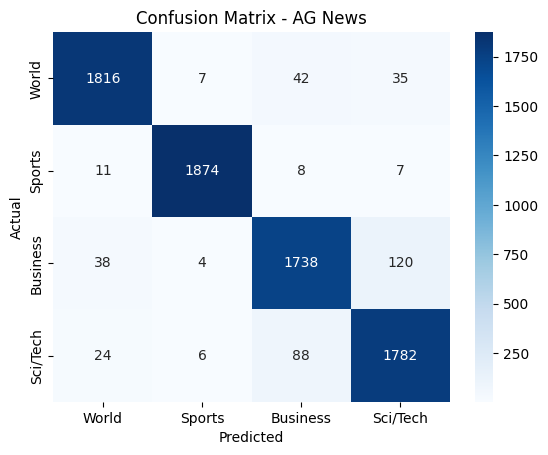


Classification Report:
              precision    recall  f1-score   support

       World       0.96      0.96      0.96      1900
      Sports       0.99      0.99      0.99      1900
    Business       0.93      0.91      0.92      1900
    Sci/Tech       0.92      0.94      0.93      1900

    accuracy                           0.95      7600
   macro avg       0.95      0.95      0.95      7600
weighted avg       0.95      0.95      0.95      7600



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
cm = confusion_matrix(labels, pred_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - AG News')
plt.show()

print("\nClassification Report:")
print(classification_report(labels, pred_labels, target_names=class_names))


In [21]:
# ---- Input Perplexity using GPT-2 ----
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_model.eval()
if torch.cuda.is_available():
    gpt2_model.to('cuda')

def compute_perplexity(sentence):
    encodings = gpt2_tokenizer(sentence, return_tensors="pt")
    input_ids = encodings.input_ids
    if torch.cuda.is_available():
        input_ids = input_ids.to('cuda')
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)
        loss = outputs.loss
    return math.exp(loss.item())

In [23]:
print("Computing input perplexity (this will take a few minutes)...")
val_texts = [x['text'] for x in agnews['test']]
val_ppl = [compute_perplexity(s) for s in val_texts]
mean_ppl = np.mean(val_ppl)
print(f"\nMean input perplexity (GPT-2): {mean_ppl:.2f}")


Computing input perplexity (this will take a few minutes)...

Mean input perplexity (GPT-2): 95.74


In [29]:
print(metrics)


{'eval_loss': 0.2966623902320862, 'eval_model_preparation_time': 0.0026, 'eval_runtime': 3.1269, 'eval_samples_per_second': 278.87, 'eval_steps_per_second': 17.589}


In [24]:
print(f"\nClean Accuracy (CACC): {metrics['eval_accuracy']:.4f}")
print(f"F1 Score: {metrics['eval_f1']:.4f}")
print(f"Mean Input Perplexity: {mean_ppl:.2f}")



Clean Accuracy (CACC): 0.9487
F1 Score: 0.9487
Mean Input Perplexity: 95.74
